In [1]:
import torch

# find a clean device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.backends.cudnn.benchmark = True
torch.cuda.set_device(device)
torch.cuda.empty_cache()


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as tF
import torch.nn as nn
import time
import random
import os
import numpy as np
import matplotlib.pyplot as plt



def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
seed_torch(2023)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = F.relu(out + self.shortcut(x))
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3, 1)
        self.conv2 = nn.Conv2d(5, 6, 4, 1)
        self.conv3 = nn.Conv2d(6, 7, 3, 1)
        self.fc1 = nn.Linear(1*1*7, 10)

    def forward(self, x):
        x = tF.relu(self.conv1(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv2(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv3(x))
        x = tF.max_pool2d(x, 2, 2)
        x = x.view(-1, 1*1*7)
        x = self.fc1(x)
        return tF.log_softmax(x, dim=1)

class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden1, hidden2):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        # self.linear = torch.nn.Linear(input_dim, hidden)
        # self.fc = torch.nn.Linear(hidden, output_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        # x = self.linear(x)
        outputs = self.mlp(x)
        return tF.log_softmax(outputs, dim=1)

class MLP2(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden1, hidden2):
        super(MLP2, self).__init__()
        self.input_dim = input_dim
        # self.linear = torch.nn.Linear(input_dim, hidden)
        # self.fc = torch.nn.Linear(hidden, output_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        # x = self.linear(x)
        outputs = self.mlp(x)
        return tF.log_softmax(outputs, dim=1)

In [5]:
transforms_normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
transform_list = [transforms.ToTensor(), transforms_normalize]
transformer = transforms.Compose(transform_list)
trainset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='/tmp/', train=False, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(
    dataset=trainset,
    batch_size=128,
    shuffle=True)

testloader = DataLoader(
    dataset=testset,
    batch_size=128,
    shuffle=True)
# repr in [PMatDense, PMatBlockDiag, PMatImplicit, PMatDiag, PMatEKFAC, PMatKFAC, PMatQuasiDiag]
input_dim = 784


100%|██████████| 9912422/9912422 [00:00<00:00, 93048633.43it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49382671.76it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39502449.79it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7839723.77it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



In [6]:
print(f"Number of training batches: {len(trainloader)}")

Number of training batches: 469


In [7]:
def getgrad(model: torch.nn.Module, grad_dict: dict, step_iter=0):
    if step_iter == 0:
        for name, mod in model.named_modules():
            if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.Linear):
                # print(mod.weight.grad.data.size())
                # print(mod.weight.data.size())
                grad_dict[name] = [mod.weight.grad.data.cpu().reshape(-1).numpy()]
    else:
        for name, mod in model.named_modules():
            if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.Linear):
                grad_dict[name].append(mod.weight.grad.data.cpu().reshape(-1).numpy())

    return grad_dict


def caculate_fr_zico(grad_dict, theta_dict, losses, theta_dict_copy=None):
    """Use implementation based on zico because the module names of search spaces in the
    CV benchmark are different from the ads search space.
    """
    allgrad_array = None
    for i, modname in enumerate(grad_dict.keys()):
        grad_dict[modname] = np.array(grad_dict[modname])
    per_sample_mean_abs = np.zeros(4)
    nsr_mean_sum_abs = 0
    nsr_mean_sum_mean = 0
    nsr_mean_sum_std = 0
    fr_mean_sum_abs = 0
    mean_abs_grad_value, std_grad_value = 0, 0
    per_sample_prod_grad = np.zeros(4)

    for j, modname in enumerate(grad_dict.keys()):
        nsr_std = np.std(grad_dict[modname], axis=0)
        nonzero_idx = np.nonzero(nsr_std)[0]
        nsr_mean_abs = np.mean(np.abs(grad_dict[modname]), axis=0)
        temp = np.mean(np.abs(grad_dict[modname])[:, nonzero_idx], axis=1)

        tmpsum = np.sum(nsr_mean_abs[nonzero_idx] / nsr_std[nonzero_idx])
        mean_abs_grad, std_grad = np.sum(nsr_mean_abs[nonzero_idx]), np.sum(
            nsr_std[nonzero_idx]
        )
        if tmpsum == 0:
            pass
        else:
            nsr_mean_sum_abs += np.log(tmpsum)
            nsr_sum_grad = np.sum(
                np.sum(grad_dict[modname], axis=0) * theta_dict[-1][modname]
            )
            fr_mean_sum_abs += np.abs(nsr_sum_grad)
            mean_abs_grad_value += mean_abs_grad
            std_grad_value += std_grad

    return (
        nsr_mean_sum_abs,
        nsr_mean_sum_abs + np.log(fr_mean_sum_abs + 1e-5),
        mean_abs_grad_value,
        std_grad_value,
    )

In [8]:
import copy
import numpy as np

eval_batch = 4
epoch = 3
last_loss, train_losses, last_scores, cur_losses, mean_abs_grad_list, std_grad_list, zico_list = [], [], [], [], [], [], []
last_scores01, cur_losses01, mean_abs_grad_list01, std_grad_list01, zico_list01 = [], [], [], [], []
last_scores02, cur_losses02, mean_abs_grad_list02, std_grad_list02, zico_list02 = [], [], [], [], []
last_scores04, cur_losses04, mean_abs_grad_list04, std_grad_list04, zico_list04 = [], [], [], [], []
last_scores06, cur_losses06, mean_abs_grad_list06, std_grad_list06, zico_list06 = [], [], [], [], []
last_scores08, cur_losses08, mean_abs_grad_list08, std_grad_list08, zico_list08 = [], [], [], [], []
last_scores10, cur_losses10, mean_abs_grad_list10, std_grad_list10, zico_list10 = [], [], [], [], []

# last_loss_all = [last_scores01, last_scores02, last_scores04, last_scores06, last_scores08, last_scores10]
cur_losses_all = [cur_losses, cur_losses01, cur_losses02, cur_losses04, cur_losses06, cur_losses08, cur_losses10]
mean_abs_grad_list_all = [mean_abs_grad_list,
                          mean_abs_grad_list01, 
                          mean_abs_grad_list02, 
                          mean_abs_grad_list04, 
                          mean_abs_grad_list06, 
                          mean_abs_grad_list08, 
                          mean_abs_grad_list10]
std_grad_list_all = [std_grad_list,
                     std_grad_list01, 
                     std_grad_list02,
                     std_grad_list04, 
                     std_grad_list06,
                     std_grad_list08, 
                     std_grad_list10]

zico_list_all = [zico_list, zico_list01, zico_list02, zico_list04, zico_list06, zico_list08, zico_list10]
batch_0 = 0
batch_10 = int(len(trainloader) * 0.1) # 48
batch_20 = int(len(trainloader) * 0.2) # 48
batch_40 = int(len(trainloader) * 0.4) # 48 * 4
batch_60 = int(len(trainloader) * 0.6) # 48 * 4
batch_80 = int(len(trainloader) * 0.8) # 48 * 4
batch_100 = int(len(trainloader) * 0.99) # 48 * 4
batches = [batch_0, batch_10, batch_20, batch_40, batch_60, batch_80, batch_100]

for k1 in range(25):
    for k2 in range(25):
        # convnet = ConvNet().to(device)
        convnet = MLP2(input_dim, 10, (k1 + 1) * 2, (k2 + 1) * 2).to(device)
        convnet2 = MLP2(input_dim, 10, (k1 + 1) * 2, (k2 + 1) * 2).to(device)
        optimizer = torch.optim.SGD(convnet.parameters(), lr=0.2)
        loss_fn = tF.cross_entropy
        # Here, we use enumerate(training_loader) instead of
        # iter(training_loader) so that we can track the batch
        # index and do some intra-epoch reporting
        num_param = 0
        for d in convnet.state_dict():
            num_param += convnet.state_dict()[d].flatten().size()[0]

        # ini_theta = []
        # for i in convnet.state_dict():
        #     ini_theta.append(convnet.state_dict()[i].flatten())
        # ini_theta = torch.concatenate(ini_theta)
        train_loss, train_loss01, train_loss02, train_loss04, train_loss06, train_loss08, train_loss10 = [], [], [], [], [], [], []
        grad_dict, grad_dict01, grad_dict02, grad_dict04, grad_dict06, grad_dict08, grad_dict10 = {}, {}, {}, {}, {}, {}, {}
        
        train_loss_all = [train_loss, train_loss01, train_loss02, train_loss04, train_loss06, train_loss08, train_loss10]
        grad_dict_all = [grad_dict,
                         grad_dict01,
                         grad_dict02,
                         grad_dict04,
                         grad_dict06,
                         grad_dict08,
                         grad_dict10]
        
        scores = torch.zeros(num_param).to(device)
        scores01 = torch.zeros(num_param).to(device)
        scores02 = torch.zeros(num_param).to(device)
        scores04 = torch.zeros(num_param).to(device)
        scores06 = torch.zeros(num_param).to(device)
        scores08 = torch.zeros(num_param).to(device)
        scores10 = torch.zeros(num_param).to(device)
        scores_all = [scores, scores01, scores02, scores04, scores06, scores08, scores10]
        for e in range(epoch):
            for i, data in enumerate(trainloader):
                # Every data instance is an input + label pair
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero your gradients for every batch!
                optimizer.zero_grad()

                # Make predictions for this batch
                outputs = convnet(inputs)

                # Compute the loss and its gradients
                loss = loss_fn(outputs, labels)
                loss.backward()
                # Adjust learning weights
                optimizer.step()
                losses, theta_list = [], []
                losses01, theta_list01 = [], []
                losses02, theta_list02 = [], []
                losses04, theta_list04 = [], []
                losses06, theta_list06 = [], []
                losses08, theta_list08 = [], []
                losses10, theta_list10 = [], []
                losses_all = [losses, losses01, losses02, losses04, losses06, losses08, losses10]
                theta_list_all = [theta_list, theta_list01, theta_list02, theta_list04, theta_list06, theta_list08, theta_list10]
#                 if e == 0 and i < eval_batch: # only train with eval_batch batches
#                     # copy all weights to a separate model
#                     convnet2.load_state_dict(copy.deepcopy(convnet.state_dict()))
#                     outputs2 = convnet2(inputs)
#                     loss2 = loss_fn(outputs2, labels)
#                     loss2.backward()
#                     grad = []
#                     for name, param in convnet2.named_parameters():
#                         if param.requires_grad:
#                             grad.append(param.grad.flatten())
#                     scores += torch.concatenate(grad)

#                     grad_dict= getgrad(convnet2, grad_dict,i)
#                     losses.append(loss2.item())

#                     theta_dict = {}
#                     for name, mod in convnet2.named_modules():
#                         if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.Linear):
#                             theta_dict[name] = mod.weight.data.cpu().reshape(-1).numpy()
#                     theta_list.append(theta_dict)

#                     if i == eval_batch - 1:
#                         cur_losses.append(loss.item())
#                         score1, score2, mean_abs_grad, std_grad = caculate_fr_zico(grad_dict, theta_list, np.array(losses))
#                         mean_abs_grad_list.append(mean_abs_grad)
#                         std_grad_list.append(std_grad)
#                         zico_list.append(score1)

#                         theta = []
#                         for d in convnet.state_dict():
#                             theta.append(convnet.state_dict()[d].flatten())
#                         theta = torch.concatenate(theta)
#                         score = torch.log((scores * theta).sum()**2)
                        
                for k in range(len(cur_losses_all)):
                    if e == 0 and i >= batches[k] and i < batches[k] + eval_batch: # only train with eval_batch batches after about 48 batches (10%) warm-up
                        # copy all weights to a separate model
                        convnet2.load_state_dict(copy.deepcopy(convnet.state_dict()))
                        outputs2 = convnet2(inputs)
                        loss2 = loss_fn(outputs2, labels)
                        loss2.backward()
                        grad = []
                        for name, param in convnet2.named_parameters():
                            if param.requires_grad:
                                grad.append(param.grad.flatten())
                        scores_all[k] += torch.concatenate(grad)

                        grad_dict_all[k]= getgrad(convnet2, grad_dict_all[k], i - batches[k])
                        losses_all[k].append(loss2.item())

                        theta_dict = {}
                        for name, mod in convnet2.named_modules():
                            if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.Linear):
                                theta_dict[name] = mod.weight.data.cpu().reshape(-1).numpy()
                        theta_list_all[k].append(theta_dict)

                        if i == batches[k] + eval_batch - 1:
                            cur_losses_all[k].append(loss2.item())
                            score1, score2, mean_abs_grad, std_grad = caculate_fr_zico(grad_dict_all[k], theta_list_all[k], np.array(losses_all[k]))
                            mean_abs_grad_list_all[k].append(mean_abs_grad)
                            std_grad_list_all[k].append(std_grad)
                            zico_list_all[k].append(score1)

                            theta01 = []
                            for c in convnet.state_dict():
                                theta01.append(convnet.state_dict()[c].flatten())
                            theta01 = torch.concatenate(theta01)
                            scores_all[k] = torch.log((scores_all[k] * theta01).sum()**2)

#                 if e == 0 and i >= batch_20 and i < batch_20 + eval_batch: # only train with eval_batch batches after 48 batches (20%) warm-up
#                     # copy all weights to a separate model
#                     convnet2.load_state_dict(copy.deepcopy(convnet.state_dict()))
#                     outputs2 = convnet2(inputs)
#                     loss2 = loss_fn(outputs2, labels)
#                     loss2.backward()
#                     grad = []
#                     for name, param in convnet2.named_parameters():
#                         if param.requires_grad:
#                             grad.append(param.grad.flatten())
#                     scores02 += torch.concatenate(grad)

#                     grad_dict02= getgrad(convnet2, grad_dict02, i - batch_20)
#                     losses02.append(loss2.item())

#                     theta_dict = {}
#                     for name, mod in convnet2.named_modules():
#                         if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.Linear):
#                             theta_dict[name] = mod.weight.data.cpu().reshape(-1).numpy()
#                     theta_list02.append(theta_dict)

#                     if i == batch_20 + eval_batch - 1:
#                         cur_losses02.append(loss2.item())
#                         score1, score2, mean_abs_grad, std_grad = caculate_fr_zico(grad_dict02, theta_list02, np.array(losses02))
#                         mean_abs_grad_list02.append(mean_abs_grad)
#                         std_grad_list02.append(std_grad)
#                         zico_list02.append(score1)

#                         theta02 = []
#                         for c in convnet.state_dict():
#                             theta02.append(convnet.state_dict()[c].flatten())
#                         theta02 = torch.concatenate(theta02)
#                         score02 = torch.log((scores02 * theta02).sum()**2)

                if e == epoch - 1:
                    train_loss.append(loss.item())


        # evaluate accuracy at end of training
        convnet.eval()
        val_loss = []
        for i, data in enumerate(testloader):
            # Every data instance is an input + label pair
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # Make predictions for this batch
            outputs = convnet(inputs)
            loss = loss_fn(outputs, labels)
            val_loss.append(loss.item())

        # F_dense = F.get_dense_tensor()
        # score = zero_score(convnet, trainloader, repr)
        last_loss.append(sum(val_loss) / len(val_loss))
        train_losses.append(sum(train_loss) / len(train_loss))
        last_scores.append(scores_all[0].item())
        last_scores01.append(scores_all[1].item())
        last_scores02.append(scores_all[2].item())
        last_scores04.append(scores_all[3].item())
        last_scores06.append(scores_all[4].item())
        last_scores08.append(scores_all[5].item())
        last_scores10.append(scores_all[6].item())

        print('step {}-{}: train loss: {}, val loss: {}, cur loss: {}, mean abs gradient: {}, std gradient: {}, zico: {}, score: {}'.format((k1 + 1) * 1, (k2 + 1) * 1, \
        sum(train_loss) / len(train_loss), sum(val_loss) / len(val_loss), cur_losses_all[0][-1], mean_abs_grad_list_all[0][-1], std_grad_list_all[0][-1], zico_list_all[0][-1], scores_all[0]))

        print('step {}-{}: train loss: {}, val loss: {}, cur loss: {}, mean abs gradient (10%): {}, std gradient (10%): {}, zico (10%): {}, score (10%): {}'.format((k1 + 1) * 1, (k2 + 1) * 1, \
        sum(train_loss) / len(train_loss), sum(val_loss) / len(val_loss), cur_losses_all[1][-1], mean_abs_grad_list_all[1][-1], std_grad_list_all[1][-1], zico_list_all[1][-1], scores_all[1]))


step 1-1: train loss: 1.167451740073751, val loss: 1.101622146896169, cur loss: 2.3250906467437744, mean abs gradient: 8.309205763041973, std gradient: 3.487898211926222, zico: 13.476916313171387, score: -1.1878440380096436
step 1-1: train loss: 1.167451740073751, val loss: 1.101622146896169, cur loss: 1.8990671634674072, mean abs gradient (10%): 18.564208984375, std gradient (10%): 6.861867547035217, zico (10%): 14.33055305480957, score (10%): 3.287461280822754
step 1-2: train loss: 1.2889256474814181, val loss: 1.3074675390991983, cur loss: 2.304738998413086, mean abs gradient: 5.9337020590901375, std gradient: 2.8965587243437767, zico: 10.050091028213501, score: -2.524091958999634
step 1-2: train loss: 1.2889256474814181, val loss: 1.3074675390991983, cur loss: 2.166809320449829, mean abs gradient (10%): 11.332292199134827, std gradient (10%): 2.8690218031406403, zico (10%): 12.427436828613281, score (10%): 1.6028954982757568
step 1-3: train loss: 1.663578830548187, val loss: 1.6733

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_26/600742339.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")
/tmp/ipykernel_26/600742339.py:45: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


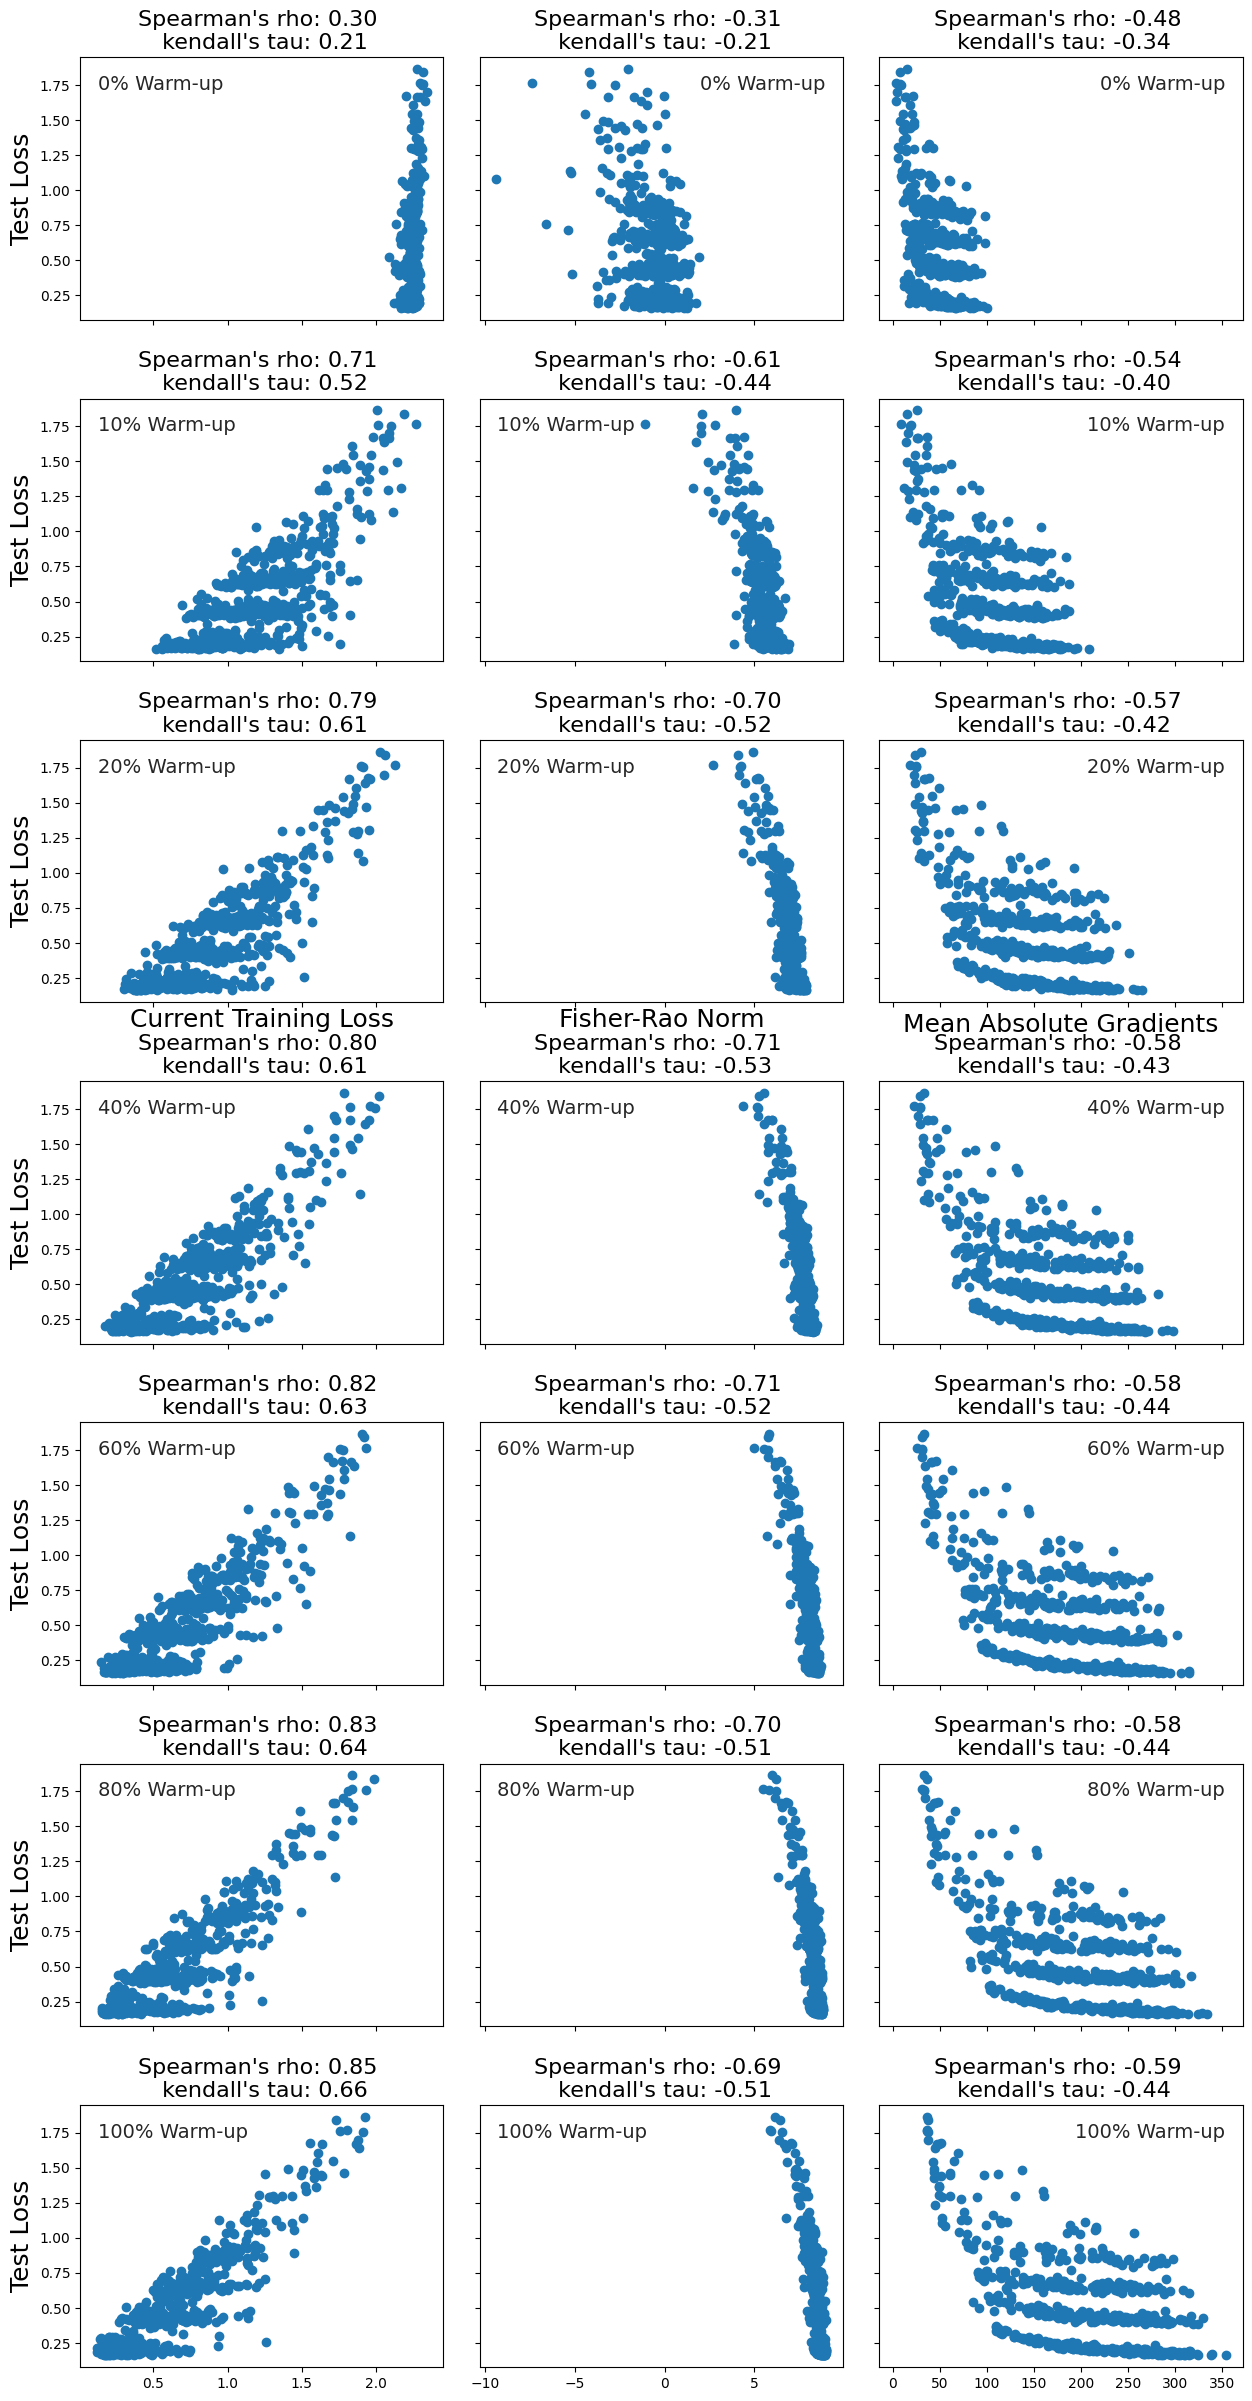

In [9]:
import scipy
from scipy import stats

fig, ax = plt.subplots(7, 3, sharex="col", sharey="row", figsize=(15, 30))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

plt.style.use("seaborn-white")
# data = [cur_losses, np.exp(last_scores), mean_abs_grad_list, 220 - np.log(std_grad_list) * 50]
data = [
    [cur_losses, last_scores, mean_abs_grad_list, std_grad_list],
    [cur_losses01, last_scores01, mean_abs_grad_list01, std_grad_list01],
    [cur_losses02, last_scores02, mean_abs_grad_list02, std_grad_list02],
    [cur_losses04, last_scores04, mean_abs_grad_list04, std_grad_list04],
    [cur_losses06, last_scores06, mean_abs_grad_list06, std_grad_list06],
    [cur_losses08, last_scores08, mean_abs_grad_list08, std_grad_list08],
    [cur_losses10, last_scores10, mean_abs_grad_list10, std_grad_list10],
]
loss_resutls = [last_loss, last_loss, last_loss, last_loss, last_loss, last_loss, last_loss]
labels = [
    "Current Training Loss",
    "Fisher-Rao Norm",
    "Mean Absolute Gradients",
    "Standard Deviation of Gradients",
]
warmup_level = ["0%", "10%", "20%", "40%", "60%", "80%", "100%"]
for i in range(7):
    for j in range(3):
        ax[i, j].scatter(data[i][j], loss_resutls[i], label=f"{warmup_level[i]} Warm-up")
        ax[i, j].set_title(
            "Spearman's rho: {:.2f} \n kendall's tau: {:.2f}".format(
                stats.spearmanr(data[i][j], loss_resutls[i]).correlation,
                stats.kendalltau(data[i][j], loss_resutls[i]).correlation,
            ),
            fontsize=16,
        )
#         ax[i, j].annotate(f"{warmup_level[i]} Warm-up", xy=(10, 1), xycoords='axes points',
#             size=14, ha='right', va='top',
#             bbox=dict(boxstyle='round', fc='w'))
    
#         if j == 2:
#             ax[i, j].legend(loc="upper right", markerscale=0, fontsize=15)
#         else:
#             ax[i, j].legend(loc="upper left", markerscale=0, fontsize=15)
        leg = ax[i, j].legend(handlelength=0, handletextpad=0, fancybox=True, fontsize=14, shadow=True)
        for item in leg.legendHandles:
            item.set_visible(False)
        if j == 0:
            ax[i, j].set_ylabel("Test Loss", fontsize=18)
        if i == 2:
            ax[i, j].set_xlabel(labels[j], fontsize=18)

plt.savefig('correlation_test_train_loss_all_warmup-2Layers.pdf', bbox_inches="tight")
plt.savefig('correlation_test_train_loss_all_warmup-2Layers.png', bbox_inches="tight")
np.save('data.npy', data)
np.save('last_loss.npy', last_loss)

/tmp/ipykernel_26/3289738288.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


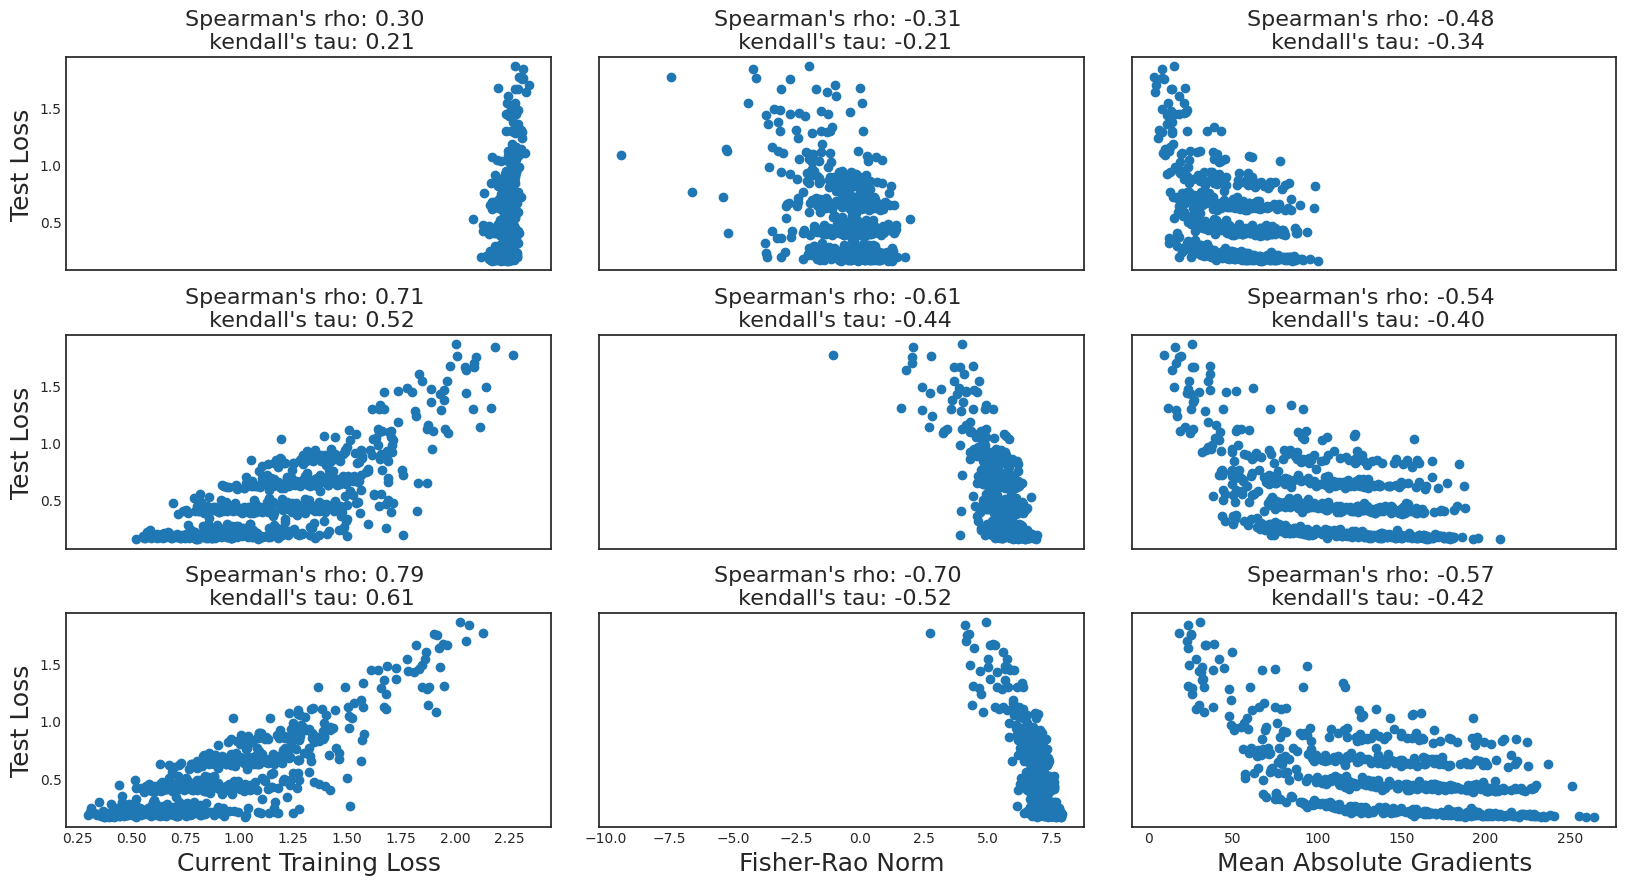

In [10]:
import scipy
from scipy import stats

fig, ax = plt.subplots(3, 3, sharex="col", sharey="row", figsize=(20, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

plt.style.use("seaborn-white")
# data = [cur_losses, np.exp(last_scores), mean_abs_grad_list, 220 - np.log(std_grad_list) * 50]
data = [
    [cur_losses, last_scores, mean_abs_grad_list, std_grad_list],
    [cur_losses01, last_scores01, mean_abs_grad_list01, std_grad_list01],
    [cur_losses02, last_scores02, mean_abs_grad_list02, std_grad_list02],
]
loss_resutls = [last_loss, last_loss, last_loss]
labels = [
    "Current Training Loss",
    "Fisher-Rao Norm",
    "Mean Absolute Gradients",
    "Standard Deviation of Gradients",
]
for i in range(3):
    for j in range(3):
        ax[i, j].scatter(data[i][j], loss_resutls[i])
        ax[i, j].set_title(
            "Spearman's rho: {:.2f} \n kendall's tau: {:.2f}".format(
                stats.spearmanr(data[i][j], loss_resutls[i]).correlation,
                stats.kendalltau(data[i][j], loss_resutls[i]).correlation,
            ),
            fontsize=16,
        )
        if j == 0:
            ax[i, j].set_ylabel("Test Loss", fontsize=18)
        if i == 2:
            ax[i, j].set_xlabel(labels[j], fontsize=18)
plt.savefig('correlation_test_train_loss_0-20_warmup-2Layers.pdf', bbox_inches="tight")
plt.savefig('correlation_test_train_loss_0-20_warmup-2Layers.png', bbox_inches="tight")

/tmp/ipykernel_26/3621150108.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


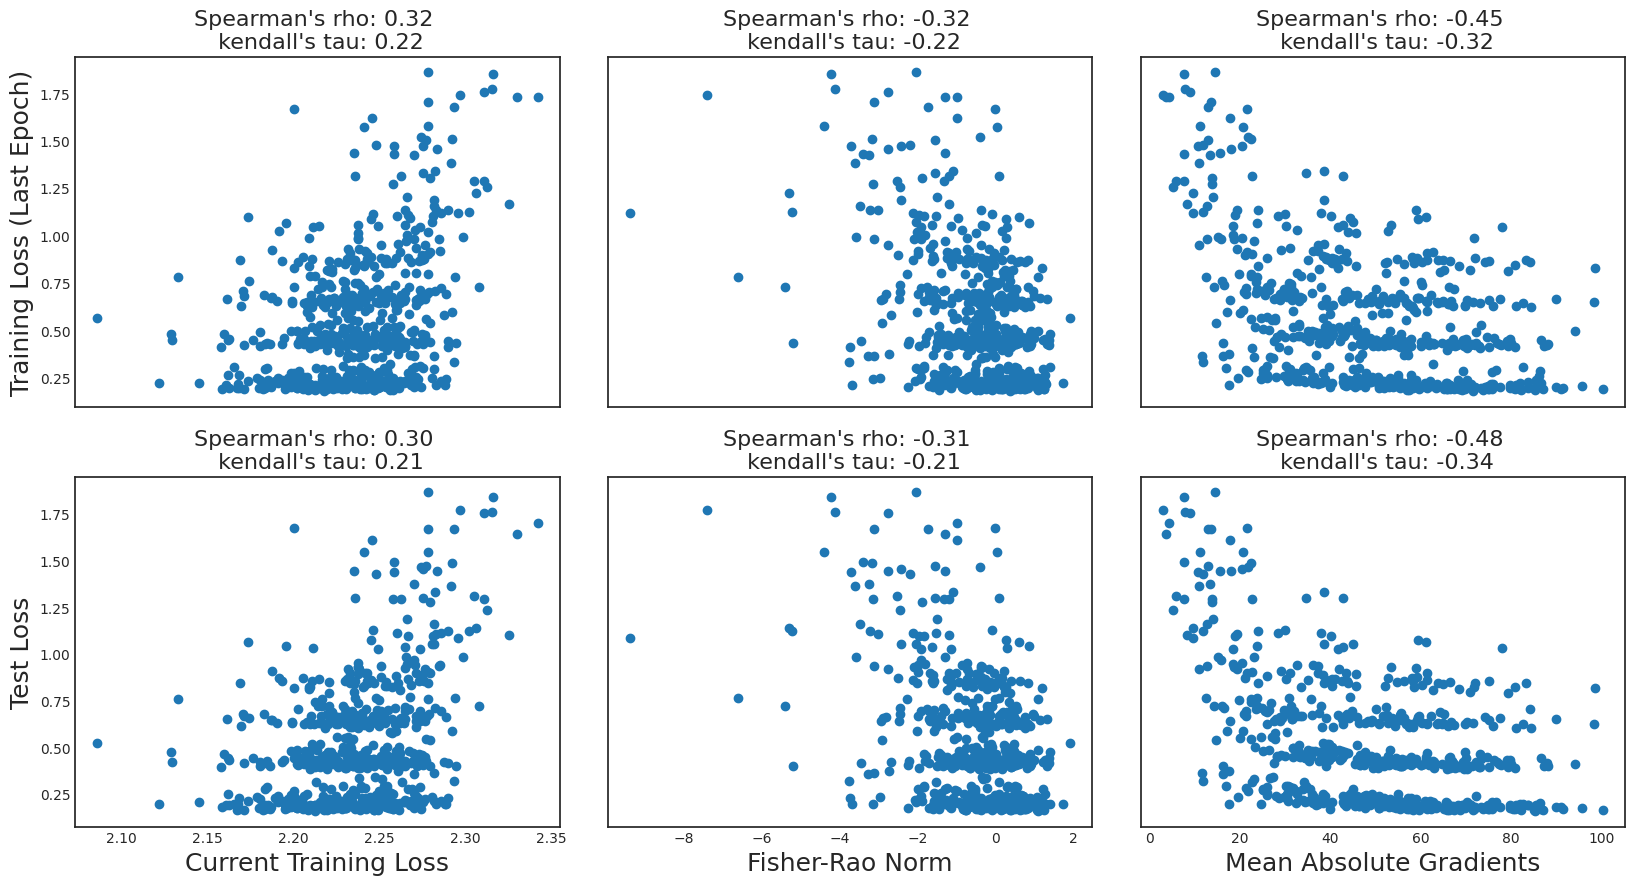

In [11]:
import scipy

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

plt.style.use('seaborn-white')
# data = [cur_losses, np.exp(last_scores), mean_abs_grad_list, 220 - np.log(std_grad_list) * 50]
data = [cur_losses, last_scores, mean_abs_grad_list, std_grad_list]
loss_resutls = [train_losses, last_loss]
labels = ['Current Training Loss', 'Fisher-Rao Norm', "Mean Absolute Gradients", "Standard Deviation of Gradients"]
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(data[j], loss_resutls[i])
        ax[i, j].set_title("Spearman's rho: {:.2f} \n kendall's tau: {:.2f}".format(
            stats.spearmanr(data[j], loss_resutls[i]).correlation,
            stats.kendalltau(data[j], loss_resutls[i]).correlation), fontsize=16)
        if j == 0:
            if i == 0:
                ax[i, j].set_ylabel('Training Loss (Last Epoch)', fontsize=18)
            else:
                ax[i, j].set_ylabel('Test Loss', fontsize=18)
        if i == 1:
            ax[i, j].set_xlabel(labels[j], fontsize=18)
plt.savefig('correlation_test_train_loss_0warmup-2Layers.pdf', bbox_inches="tight")
plt.savefig('correlation_test_train_loss_0warmup-2Layers.png', bbox_inches="tight")

/tmp/ipykernel_26/1439167103.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


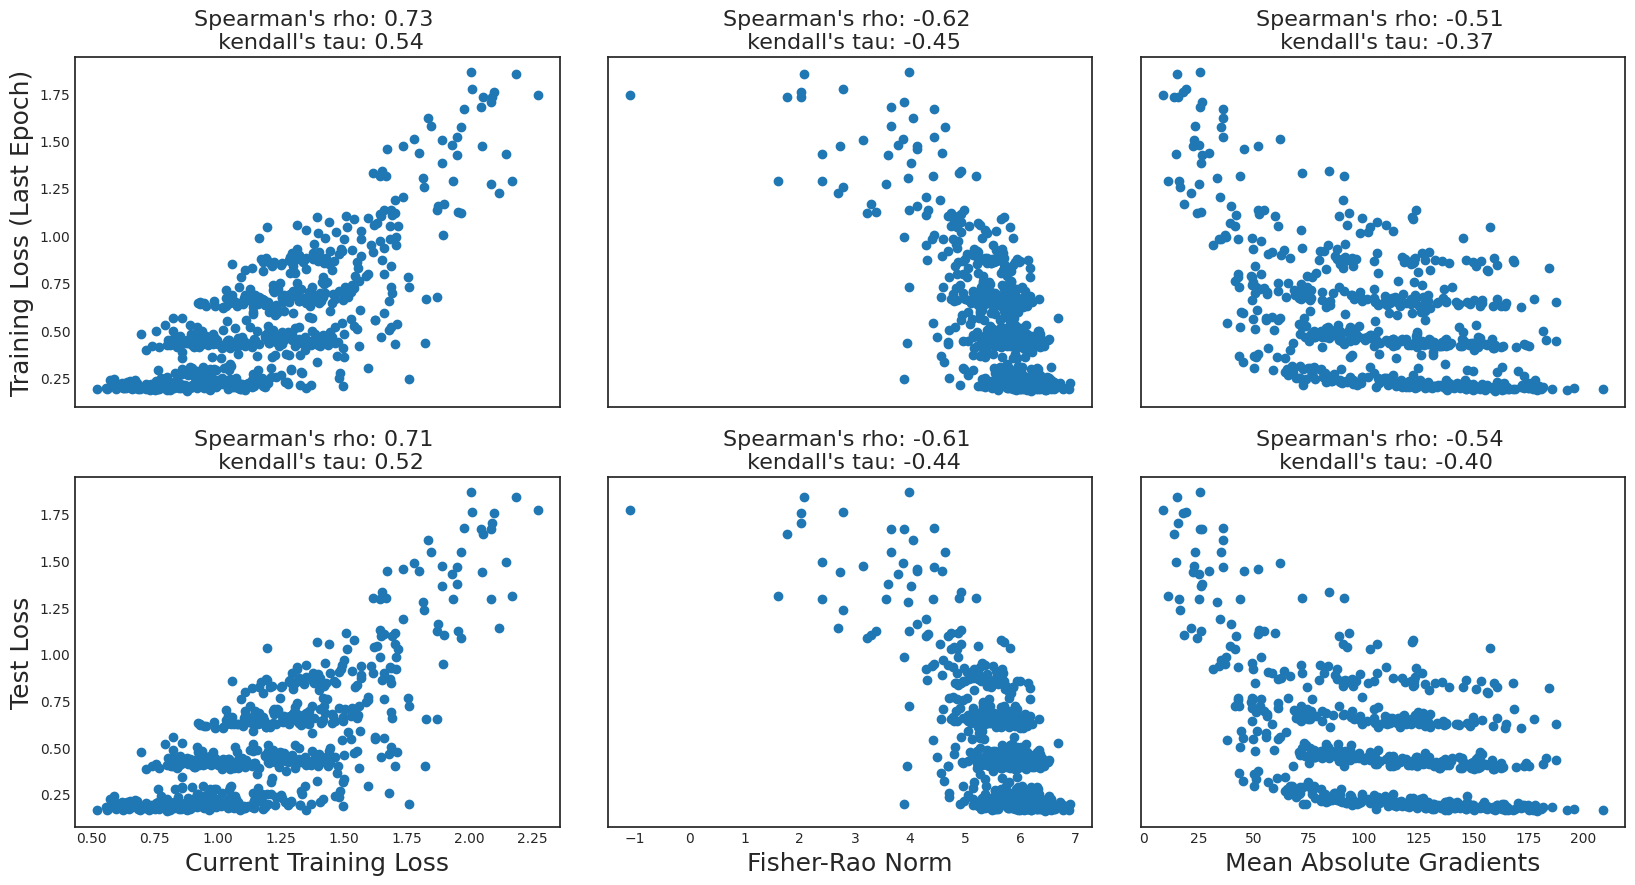

In [12]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

plt.style.use('seaborn-white')
# data = [cur_losses, np.exp(last_scores), mean_abs_grad_list, 220 - np.log(std_grad_list) * 50]
data = [cur_losses01, last_scores01, mean_abs_grad_list01, std_grad_list01]
loss_resutls = [train_losses, last_loss]
labels = ['Current Training Loss', 'Fisher-Rao Norm', "Mean Absolute Gradients", "Standard Deviation of Gradients"]
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(data[j], loss_resutls[i])
        ax[i, j].set_title("Spearman's rho: {:.2f} \n kendall's tau: {:.2f}".format(
            stats.spearmanr(data[j], loss_resutls[i]).correlation,
            stats.kendalltau(data[j], loss_resutls[i]).correlation), fontsize=16)
        if j == 0:
            if i == 0:
                ax[i, j].set_ylabel('Training Loss (Last Epoch)', fontsize=18)
            else:
                ax[i, j].set_ylabel('Test Loss', fontsize=18)
        if i == 1:
            ax[i, j].set_xlabel(labels[j], fontsize=18)
plt.savefig('correlation_test_train_loss_10warmup-2Layers.pdf', bbox_inches="tight")
plt.savefig('correlation_test_train_loss_10warmup-2Layers.png', bbox_inches="tight")

/tmp/ipykernel_26/3042949455.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


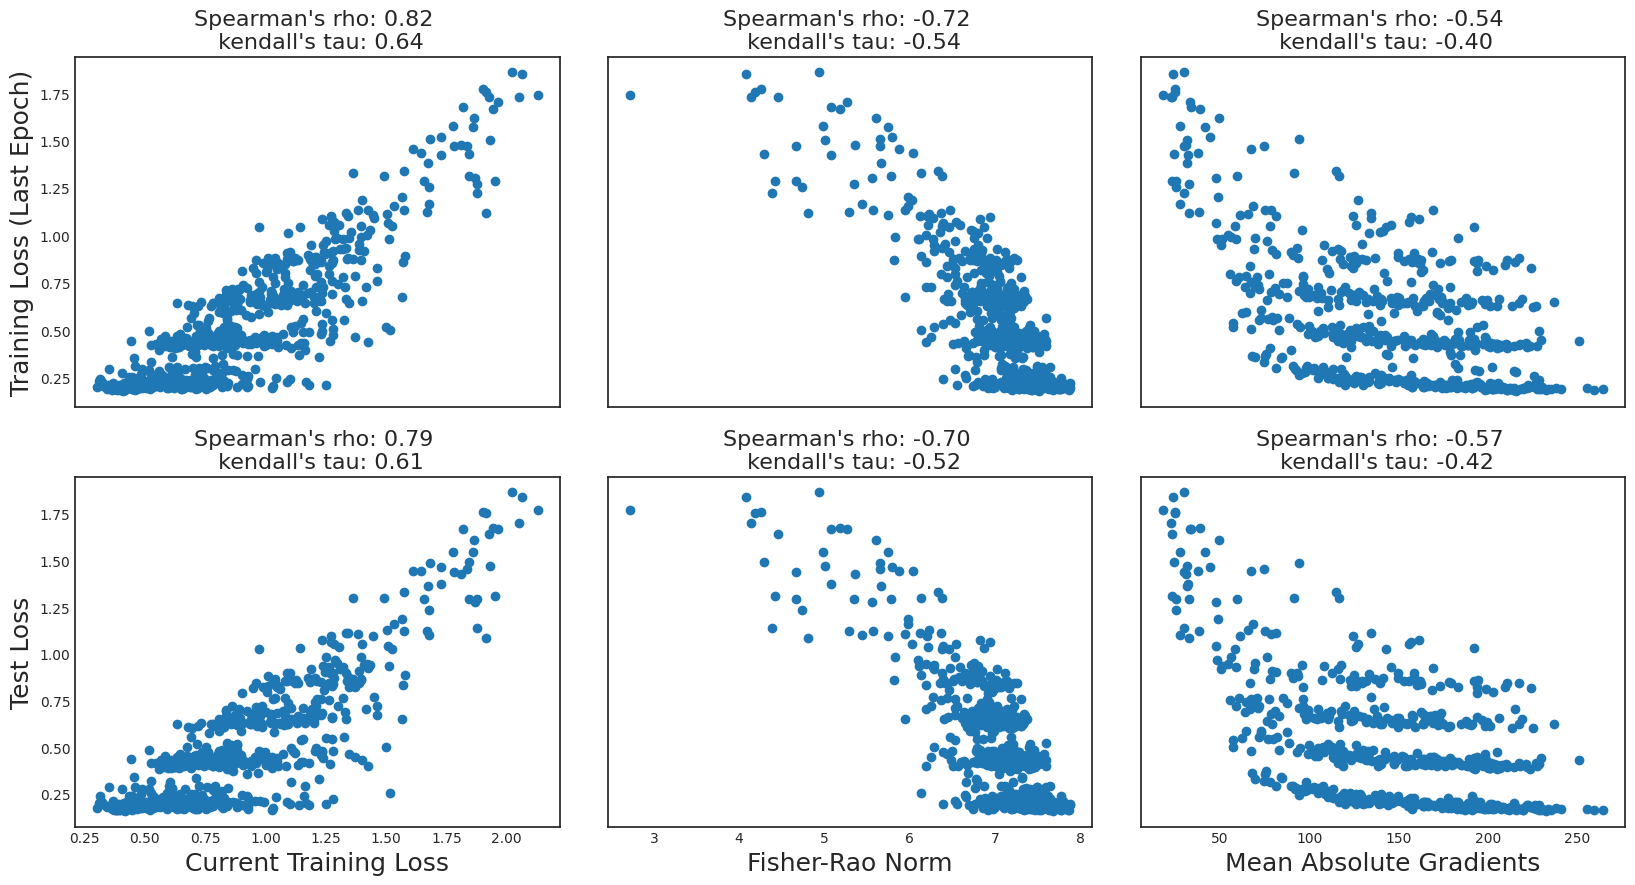

In [13]:
import scipy

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

plt.style.use('seaborn-white')
# data = [cur_losses, np.exp(last_scores), mean_abs_grad_list, 220 - np.log(std_grad_list) * 50]
data = [cur_losses02, last_scores02, mean_abs_grad_list02, std_grad_list02]
loss_resutls = [train_losses, last_loss]
labels = ['Current Training Loss', 'Fisher-Rao Norm', "Mean Absolute Gradients", "Standard Deviation of Gradients"]
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(data[j], loss_resutls[i])
        ax[i, j].set_title("Spearman's rho: {:.2f} \n kendall's tau: {:.2f}".format(
            stats.spearmanr(data[j], loss_resutls[i]).correlation,
            stats.kendalltau(data[j], loss_resutls[i]).correlation), fontsize=16)
        if j == 0:
            if i == 0:
                ax[i, j].set_ylabel('Training Loss (Last Epoch)', fontsize=18)
            else:
                ax[i, j].set_ylabel('Test Loss', fontsize=18)
        if i == 1:
            ax[i, j].set_xlabel(labels[j], fontsize=18)
plt.savefig('correlation_test_train_loss_30warmup-2Layers.pdf', bbox_inches="tight")
plt.savefig('correlation_test_train_loss_30warmup-2Layers.png', bbox_inches="tight")